In [1]:
import numpy as np

Z = 18
A = 39.948   # g / mol
I = 188.0*(10**(-6)) # MeV
K = 0.307 # MeV * cm^2 / mol
Mmu = 105.658 # MeV for muon
Me  = 0.51 # MeV for electron
rho = 1.396 # g/cm3

def beta(gamma):
    return np.sqrt(1-(1./(gamma**2)))

def gamma(KE,mass):
    return (KE/mass)+1

beta = np.vectorize(beta)
gamma = np.vectorize(gamma)

def Wmax (KE,mass):
    g = gamma(KE,mass)
    b = beta(g)
    num = 2*Me*((b*g)**2)
    den = 1 + 2*g*Me/mass + (Me/mass)**2
    return num/den

# density correction for LAr
def density(bg):

    # constants and variable names obtained from :
    # PDG elos muons table [http://pdg.lbl.gov/2016/AtomicNuclearProperties/MUE/muE_liquid_argon.pdf]
    
    C  = -5.2146
    X0 = 0.2
    X1 = 3.0
    a  = 0.19559
    m  = 3.0
    N    = 2 * np.log(10)
    
    x = np.log10(bg)
    
    if (x < X0):
        return 0.
    if (x > X1):
        return N * x + C
    addition = a*((X1-x)**m)
    return N * x + C + addition

class Eloss:

    def __init__(self,I=188,rho=1.38):
        self.I   = I   # mean excitation energy [eV]
        self.rho = rho # argon density [g/cm3]

    # set density [input in g/cm3]
    def setDensity(rho):
        self.rho = rho

    # set mean excitation energy I [input in eV]
    def setI(I):
        self.I = I

    # print argon properties currently loaded
    def PrintArInfo():
        print
        print('Argon density .............. : %.03f g/cm3')%self.rho
        print('Argon mean excitation energy : %.03f eV')%self.I
        print
        
# KE in MeV
# x in cm
# mass in MeV
def dpdx(KE,x,mass,I=I):
    g = gamma(KE,mass)
    b = beta(g)
    epsilon = (K/2.)*(Z/A)*(x*rho/(b*b))
    A0 = (2*Me*(b*g)**2)/I
    A1 = epsilon/I
    return (1./x) * epsilon * (np.log(A0) + np.log(A1) + 0.2 - (b*b) - density(b*g))

# in MeV/cm
def dedx(KE,mass,I=I,dens=True):
    g = gamma(KE,mass)
    b = beta(g)
    F = K * (Z/A)*(1/b)**2
    wmax = Wmax(KE,mass)
    a0 = 0.5*np.log( 2*Me*(b*g)**2 * wmax / (I*I) )
    ret = a0 - b*b
    if (dens == True):
        ret -= density(b*g)/2.
    return F * ret


def Tfunc(g):
    return (g-1.)*Me
def tfunc(g):
    return (g-1.)

def Fminus(b,t):
    f = (1-b*b) * ( 1 + t*t/8. - (2*t+1)*np.log(2) )
    return f
def Fplus(b,t):
    f = 2*np.log(2) - (b*b/12.) * ( 23. + 14./(t+2.) + 10./(t+2.)**2 + 4./(t+2.)**3 )
    return f

def dedxelectrons(beta,dens=True):
    g = 1./np.sqrt(1-beta*beta)
    T = Tfunc(g)
    t = tfunc(g)
    F = (Z/A) * 0.153536 * ((1./beta)**2)
    ret =  (np.log((T/I)**2)) + np.log(1.+t/2.) + Fminus(beta,t)
    if (dens == True):
        ret -= density(beta*g)
    return ret * F

def dedxpositrons(beta,dens=True):
    g = 1./np.sqrt(1-beta*beta)
    T = Tfunc(g)
    t = tfunc(g)
    F = (Z/A) * 0.153536 * ((1./beta)**2)
    ret =   (np.log((T/I)**2)) + np.log(1+t/2.) + Fplus(beta,t)
    if (dens == True):
        ret -= density(beta*g)
    return ret * F

In [2]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import datetime
from scipy.optimize import curve_fit
from scipy.special import factorial
plt.rcParams.update({'font.size': 18})

In [3]:
KEvals = np.linspace(10.,100000.,10000)
dpvals04 = []
dpvals03 = []
dpvals05 = []
dpvals30 = []
dedxvals = []
dedxvalsp = []
dedxvalsk = []
dedxvalspi = []

dpsmall = []

x = 0.49 # cm

for KE in KEvals:
    dpvals04.append(dpdx(KE,0.4,Mmu))
    dpvals05.append(dpdx(KE,0.5,Mmu))
    dpvals03.append(dpdx(KE,0.3,Mmu))
    dpvals30.append(dpdx(KE,3.0,Mmu))
    dpsmall.append(dpdx(KE,0.03,Mmu))
    dedxvals.append(rho * dedx(KE,Mmu,dens=True))
    dedxvalsp.append(rho * dedx(KE, 938.28, dens=True))
    dedxvalsk.append(rho * dedx(KE, 493.677, dens=True))
    dedxvalspi.append(rho * dedx(KE, 134.9766, dens=True))

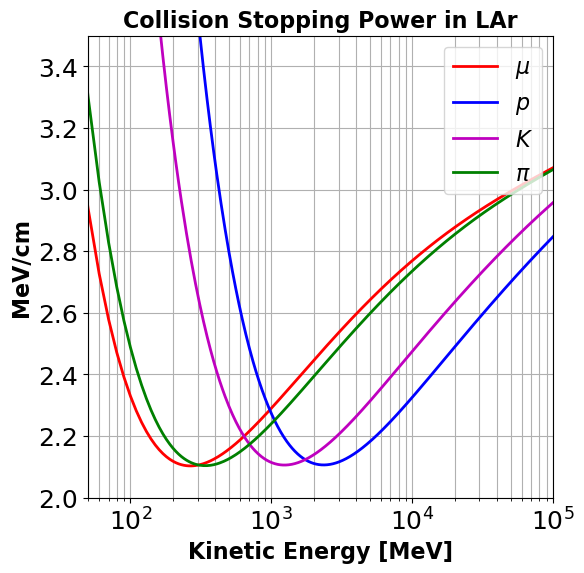

In [5]:
fig = plt.figure(figsize=(6,6))
#plt.plot(KEvals,dpvals05,'-',color='b' ,lw=3,label='$\Delta p/dx$ @ 0.5 cm')
#plt.plot(KEvals,dpvals03,'--',color='b',lw=3,label='$\Delta p/dx$ @ 0.3 cm')
#plt.plot(KEvals,dpvals30,'-.',color='b',lw=3,label='$\Delta p/dx$ @ 3.0 cm')
plt.plot(KEvals,dedxvals,color='r',lw=2,label='$μ$')
plt.plot(KEvals,dedxvalsp,color='b', lw=2, label='$p$')
plt.plot(KEvals,dedxvalsk,color='m', lw=2, label='$K$')
plt.plot(KEvals,dedxvalspi,color='g', lw=2, label='$π$')
plt.grid(which='both')
plt.xlabel('Kinetic Energy [MeV]',fontsize=16,fontweight='bold')
plt.ylabel('MeV/cm',fontsize=16,fontweight='bold')
#plt.ylim([1.75,1.85])
plt.ylim([2.0,3.5])
plt.legend(loc=1,fontsize=16)
plt.xlim([50,100000])
plt.xscale('log')
plt.title('Collision Stopping Power in LAr',fontsize=16,fontweight='bold')
plt.show()